# Comparison between global training and the use of the backtester

In this example, we try to predict whether the price will rise or fall by using the supervised learning model Bayesian Rigde Regression.

It consists of two parts. The **first part** is a "global" training of time series using all time series data (future data to train past data).
The **second part** uses the built-in backtester, which uses only past data to predict future data (prevents forward look).

**Strategy idea:** We will go long on cryptocurrencies depending on predictions of **Bayesian Rigde Regression** regarding if the price is moving up or down.

**Features for learning** -  trend indicator, moving average convergence divergence, stochastic oscillator, volatilty, logarithm of closing price, relative strenght index

To have a look at all the technical indicators we offer, go to [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html)

---

The second part uses a **specialized** version of the Quantiacs backtester for this purpose, which dramatically speeds up the backtesting process when the models should be retrained on a regular basis.

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

Learn more about **RidgeRegression** and other ML models: [**scikit-learn**](https://scikit-learn.org/stable/)

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [2]:
import logging
import xarray as xr  # xarray for data manipulation
import qnt.data as qndata  # functions for loading data
import qnt.backtester as qnbt  # built-in backtester
import qnt.ta as qnta  # technical analysis library
import qnt.stats as qnstats 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.seterr(divide = 'ignore') 

from qnt.ta.macd import macd
from qnt.ta.rsi import rsi
from qnt.ta.obv import obv
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error


In [3]:
# loading crypto data 

crypto_data = qndata.cryptodaily.load_data(tail = 365 * 5)                                           

100% (3945764 of 3945764) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


In [4]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the stochastic oscillator;
       * volatility;
       * moving average convergence divergence; 
       * logarithm of closing price; 
       * relative strenght index;
       
       These features can be modified and new ones can be added easily.
    """
   
    #trend
    trend = qnta.roc(qnta.lwma(data.sel(field='close'), 60), 1)
     
    #moving average convergence  divergence (MACD)
    macd = qnta.macd(data.sel(field='close'))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

  #volatility
    volatility = qnta.tr(data.sel(field='high'), data.sel(field='low'), data.sel(field='close'))
    volatility = volatility / data.sel(field='close')
    volatility = qnta.lwma(volatility, 14)
  
    #the logarithm of closing prices
    price = data.sel(field="close").ffill('time').bfill('time').fillna(0) # fill NaN
    price = np.log(price)

    #stochastic oscillator
    k, d = qnta.stochastic(data.sel(field='high'), data.sel(field='low'), data.sel(field='close'), 14)
    
    #relative strength index 
    rsi = qnta.rsi(data.sel(field='close'))
    
    #combine these six features
    result = xr.concat(
        [trend, macd2_signal.sel(field='close'), volatility,  d, rsi, price],
        pd.Index(
            ['trend',  'macd', 'volatility', 'stochastic_d', 'rsi', 'price'],
            name='field'
        )
    )

    return result.transpose('time', 'field', 'asset')

In [5]:
#displaying the features
my_features = get_features(crypto_data)
display(my_features.sel(field='trend').to_pandas())

asset,ADA,AUR,AVAX,BCH,BCN,BLK,BNB,BSV,BTC,BTG,...,UNI,WAVES,WDC,XCP,XEM,XLM,XMR,XPM,XPY,XRP
time,,,,,,,,,,,,,,,,,,,,,
2017-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06,-0.647694,NaN,-0.289330,-0.810402,-0.860103,0.0,-0.590563,-0.783822,-0.680601,-0.885459,...,-0.405594,-0.916351,NaN,0.0,-0.698819,-0.479241,-0.295272,0.0,0.0,-0.651493
2022-01-07,-0.786327,NaN,-0.553723,-0.895779,-0.893104,0.0,-0.723217,-0.799304,-0.764507,-0.979627,...,-0.624242,-0.967625,NaN,0.0,-0.838457,-0.582752,-0.439562,0.0,0.0,-0.691250
2022-01-08,-0.819035,NaN,-0.643076,-0.963064,-0.911384,0.0,-0.817675,-0.833769,-0.732552,-0.987402,...,-0.750235,-0.939099,NaN,0.0,-0.858252,-0.585236,-0.588311,0.0,0.0,-0.730913


In [6]:
""" Target classes for predicting if price goes up or down.
"""
def get_target_classes(data):
    price_current = data.sel(field='close')
    price_future = qnta.shift(price_current, -1)

    class_positive = 1 #prices goes up
    class_negative = 0 #price goes down

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [7]:

#displaying the target classes
my_targetclass = get_target_classes(crypto_data)
display(my_targetclass.to_pandas())

asset,ADA,AUR,AVAX,BCH,BCN,BLK,BNB,BSV,BTC,BTG,...,UNI,WAVES,WDC,XCP,XEM,XLM,XMR,XPM,XPY,XRP
time,,,,,,,,,,,,,,,,,,,,,
2017-01-14,0,1,0,0,0,1,0,0,1,0,...,0,1,0,1,0,0,0,1,1,0
2017-01-15,0,0,0,0,1,1,0,0,1,0,...,0,0,0,1,1,0,0,0,1,1
2017-01-16,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,1,0,0,1
2017-01-17,0,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,0
2017-01-18,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-07,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-08,0,0,1,1,1,0,1,1,1,1,...,1,1,0,0,1,1,1,0,0,1


In [8]:
def get_model():
    """This is a constructor for the ML model (Bayesian Ridge) which can be easily modified using
       different models
    """
    
    model =linear_model.BayesianRidge()
    return model

In [9]:
"""Create and train the models working on an asset-by-asset basis."""
asset_name_all = crypto_data.coords['asset'].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur = my_targetclass.sel(asset=asset_name).dropna('time', 'any')
        features_cur = my_features.sel(asset=asset_name).dropna('time', 'any')
        
        # align features and targets
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join='inner')
        if len(features_cur.time) < 10:
            #not enough points for training
                continue
        model = get_model()
        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

                
        except:
            logging.exception('model training failed')
print(models)

{'ADA': BayesianRidge(), 'AUR': BayesianRidge(), 'AVAX': BayesianRidge(), 'BCH': BayesianRidge(), 'BCN': BayesianRidge(), 'BLK': BayesianRidge(), 'BNB': BayesianRidge(), 'BSV': BayesianRidge(), 'BTC': BayesianRidge(), 'BTG': BayesianRidge(), 'BTS': BayesianRidge(), 'DASH': BayesianRidge(), 'DGC': BayesianRidge(), 'DGD': BayesianRidge(), 'DOGE': BayesianRidge(), 'DOT': BayesianRidge(), 'EOS': BayesianRidge(), 'ETC': BayesianRidge(), 'ETH': BayesianRidge(), 'FCT': BayesianRidge(), 'FRC': BayesianRidge(), 'FTC': BayesianRidge(), 'GNT': BayesianRidge(), 'ICP': BayesianRidge(), 'IFC': BayesianRidge(), 'IXC': BayesianRidge(), 'LINK': BayesianRidge(), 'LSK': BayesianRidge(), 'LTC': BayesianRidge(), 'MAID': BayesianRidge(), 'MNC': BayesianRidge(), 'NEO': BayesianRidge(), 'NMC': BayesianRidge(), 'NXT': BayesianRidge(), 'OMNI': BayesianRidge(), 'PPC': BayesianRidge(), 'QRK': BayesianRidge(), 'REP': BayesianRidge(), 'SOL': BayesianRidge(), 'STEEM': BayesianRidge(), 'STRAX': BayesianRidge(), 'THET

Feature: 0, Score: -0.00002
Feature: 1, Score: -0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00045
Feature: 4, Score: -0.00060
Feature: 5, Score: -0.00032


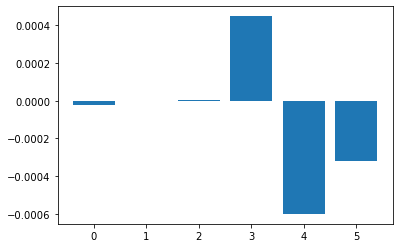

In [10]:
"""Showing which features are more important in predicting"""
importance = models[asset_name].coef_
importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [11]:
"""Performs prediction and generates output weights
    """
asset_name_all = crypto_data.coords['asset'].values
weights = xr.zeros_like(crypto_data.sel(field='close'))
    
for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna('time', 'any')
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception('model prediction failed')
print(weights)

<xarray.DataArray 'cryptodaily' (time: 1823, asset: 54)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.45198615, 0.        , 0.48630778, ..., 0.        , 0.        ,
        0.49399953],
       [0.44739117, 0.        , 0.49117449, ..., 0.        , 0.        ,
        0.49206372],
       [0.4508016 , 0.        , 0.49359236, ..., 0.        , 0.        ,
        0.49236828]])
Coordinates:
  * time     (time) datetime64[ns] 2017-01-14 2017-01-15 ... 2022-01-10
  * asset    (asset) object 'ADA' 'AUR' 'AVAX' 'BCH' ... 'XMR' 'XPM' 'XPY' 'XRP'
    field    <U5 'close'


In [12]:
#Calculating the sharpe ratio
def get_sharpe(crypto_data, weights):
    rr = qnstats.calc_relative_return(crypto_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(crypto_data, weights)
sharpe

12.76541101329208

The sharpe ratio using the method above is very high because of **forward looking**.

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2022-01-06,2.719013e+07,-0.015802,2.309350,-0.360268,-0.798523,13.003816,30.030357,1.0,54.0,0.080914,132.975684
2022-01-07,2.632118e+07,-0.031958,2.308801,-0.380713,-0.798523,12.894468,29.770755,1.0,54.0,0.080889,132.992349
2022-01-08,2.578972e+07,-0.020191,2.308213,-0.393217,-0.798523,12.818400,29.587594,1.0,54.0,0.080866,133.014595
2022-01-09,2.644573e+07,0.025437,2.307587,-0.377782,-0.798523,12.863760,29.684239,1.0,54.0,0.080850,133.034078
2022-01-10,2.569312e+07,-0.028459,2.307026,-0.395490,-0.798523,12.765411,29.450136,1.0,54.0,0.080837,142.255775


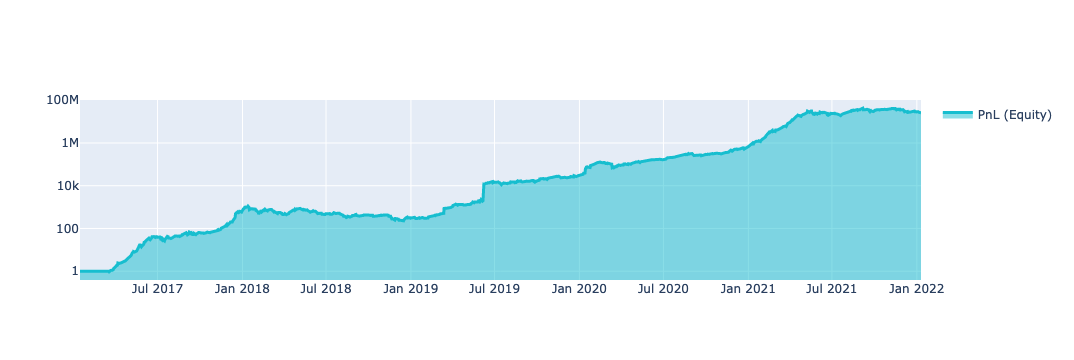

time,2022-01-10
field,
sharpe_ratio,12.765411



Ok. This strategy does not correlate with other strategies.


In [13]:
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(crypto_data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights,crypto_data)


In [14]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput='variance_weighted')

0.06283145578232922

In [15]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput='uniform_average')

0.09571199188879262

In [16]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.3946036954122388

The Sharpe ratio in the method is very high because it is **forward looking** and uses all time series. To avoid this, we use the **backtester**.

The backtester performs some transformations: It trains the model on one slice of data (data from the past) and predicts the weights for the following slice on a rolling basis:

In [17]:
"""Create and train the model working on an asset-by-asset basis."""
def train_model(data):
    asset_name_all = data.coords['asset'].values
    features_all = get_features(data)
    target_all = get_target_classes(data)


    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur = target_all.sel(asset=asset_name).dropna('time', 'any')
        features_cur = features_all.sel(asset=asset_name).dropna('time', 'any')
        
        
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join='inner')
        if len(features_cur.time) < 10:
                continue
        model = get_model()
        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

                
        except:
            logging.exception('model training failed')

    return models

In [18]:
"""Model predicts if the price is going up or down.
   Prediction is performed for several days in order to speed up the evaluation.
"""
def predict_weights(models, data):
    asset_name_all = data.coords['asset'].values
    weights = xr.zeros_like(data.sel(field='close'))
    
    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna('time', 'any')
            if len(features_cur.time) < 1:
                continue
            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e
            except:
                logging.exception('model prediction failed')
                

    return weights

In [19]:
"""Here weights are calculated using the backtester"""
weights = qnbt.backtest_ml(
    train=train_model,
    predict=predict_weights,
    train_period=2 *365,  # the data length for training in calendar days
    retrain_interval=10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit=1,  # how often retrain models after submission during evaluation (calendar days)
    predict_each_day=False,  # Is it necessary to call prediction for every day during backtesting?
    # Set it to true if you suspect that get_features is looking forward.
    competition_type='crypto_daily_long_short',  # competition type
    lookback_period=365,  # how many calendar days are needed by the predict function to generate the output
    start_date='2014-01-01',  # backtest start date
    analyze = True,
    build_plots=True  # do you need the chart?
)

Run the last iteration...


100% (1576184 of 1576184) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
100% (126304 of 126304) |################| Elapsed Time: 0:00:00 Time:  0:00:00


Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Run First Iteration...
---
Run all iterations...
Load data...


100% (6875820 of 6875820) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
100% (6343476 of 6343476) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


Backtest...


100% (6473316 of 6473316) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2014-01-01 - 2022-01-10
Sharpe Ratio = 0.8273556753062221


ERROR! The Sharpe Ratio is too low. 0.8273556753062221 < 1
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 1.


Check correlation.



WARNING! This strategy correlates with other strategies and will be rejected.
Modify the strategy to produce the different output.


The number of systems with a larger Sharpe ratio and correlation larger than 0.9: 1
The max correlation value (with systems with a larger Sharpe ratio): 0.9462133260721223
Current sharpe ratio(3y): 1.2224786167126291

---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'ADA', 'AUR', 'AVAX', 'BCH', 'BCN',…

100% (2931 of 2931) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


For improving speed you can implement your strategy using a **Single-Pass approach**. Your algorithm must return arrays for the allocation weights. In this implementation the full time series is accessible to your algo at any point in time, so you should make sure that no forward looking is taking place and your algo does not use future information for predicting the past. 

**IMPORTANT: Any** implementation in your Notebook (Single-Pass or Multi-Pass) will be processed **after submission on our servers** using a multi-pass approach in order to prevent forward looking. If the **Sharpe ratio** of your submission does not match your expectations from your Notebook research, please review your implementation: most likely some forward looking is taking place, for example by computing some global mean value which is then used for taking trading decisions.

```python
# Single-pass implementation (for prototyping)
import xarray as xr

import qnt.data as qndata
import qnt.output as qnout
import qnt.ta as qnta
import qnt.stats as qns

# load data:
data = qndata.cryptodaily_load_data(min_date="2013-05-01")

# calculate weights:
close = data.sel(field="close")
ma_slow = qnta.sma(close, 200)
ma_fast = qnta.sma(close, 20)
weights = xr.where(ma_fast > ma_slow, 1, 0)

# liquidity filter:
is_liquid = data.sel(field="is_liquid")

# set weights:
weights = weights * is_liquid
weights = weights / 10.0

# clean weights taking corner cases into account:
weights = qnout.clean(weights, data, "crypto_daily_long")

# check before submission:
qnout.check(weights, data, "crypto_daily_long")

# write results:
qnout.write(weights)

# calculate statistics for checking:
stats = qns.calc_stat(data, weights.sel(time=slice("2014-01-01",None)))
stats.to_pandas().tail()
```

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can dor example use:

! conda install -y scikit-learn

# How to load data?

Futures:
```python
data= qndata.futures.load_data(tail = 15*365, dims = ("time", "field", "asset"))
```

BTC Futures:
```python
data= qndata.cryptofutures.load_data(tail = 15*365, dims = ("time", "field", "asset"))
```

Cryptocurrencies:
```python
data= qndata.crypto.load_data(tail = 15*365, dims = ("time", "field", "asset"))
```